In [1]:
# Display settings
## Auto reload modules & inline plots
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import datetime as dt #For inputing any date or time information
from datetime import timezone #For inputing timezones
from google.cloud import bigquery          #The BigQuery API
import matplotlib.pyplot as plt      #For plotting
import numpy as np                         #For scientific computation
import os                            #For work with native operating system and directories
from pathlib import Path             #For working with file paths and directories
import pydata_google_auth                  #For authentication against Google 
import pandas as pd                        #For data manipulation and bgq --> pandas conversion
import pandas_gbq as pd_gbq #Import BigQuery data to create a pandas dataframe
import plotly.graph_objects as go # interactive plots
import pytz #For timezone calculations
import seaborn as sns                #For plotting
import warnings
import datetime

In [3]:
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:.4f}'.format
warnings.filterwarnings('ignore')

In [4]:
query = """
SELECT
  CUSTOMER_NUMBER,
  ENTERPRISE_ACCOUNT_NO,
  ENTERPRISE_ACCOUNT_NAME,
  NATIONAL_ACCOUNT,
  PAYER,
  DOCUMENT_DATE_IN_DOCUMENT,
  DOCUMENT_TYPE,
  POSTING_KEY_NAME,
  AMOUNT_IN_LOCAL_CURRENCY,
  CREDIT_CONTROL_AREA,
  AR_STATUS,
  PAYMENT_DATE
  
FROM
  `edna-data-pr-cah.VW_CORP_GFSS_NP.VW_AR_AGING`
WHERE
  (DOCUMENT_TYPE IN ('ZF',
      'VF', 'DH', 'DL', 'DZ', 'DW', 'DC'))
ORDER BY
  PAYMENT_DATE
"""

<font color='red'>check on: WHERE
  (DOCUMENT_TYPE IN ('ZF',
      'VF', 'DH', 'DL', 'DZ', 'DW', 'DC'))</font> 

In [5]:
# Import the data with imputation
bqclient = bigquery.Client()
df = bqclient.query(query).to_dataframe()

In [6]:
df

,CUSTOMER_NUMBER,ENTERPRISE_ACCOUNT_NO,ENTERPRISE_ACCOUNT_NAME,NATIONAL_ACCOUNT,PAYER,DOCUMENT_DATE_IN_DOCUMENT,DOCUMENT_TYPE,POSTING_KEY_NAME,AMOUNT_IN_LOCAL_CURRENCY,CREDIT_CONTROL_AREA,AR_STATUS,PAYMENT_DATE
0,2051130502,,,,2051130502,2021-01-20,ZF,01 - Invoice,160.000000000,PRMD,OPEN,None
1,0031009597,7100000234,7100000234 - NEW YORK PRESBYTERIAN HEALTHCARE ...,,None,2021-06-15,DH,06 - Payment difference,42.080000000,Z2140,CLEAR,None
2,0010015900,7100018407,7100018407 - NEIL MEDICAL GROUP,,None,2021-06-23,DL,04 - Other receivables,1630.190000000,Z2140,CLEAR,None
3,0010014074,7100000882,7100000882 - AMERISOURCE,,None,2023-07-03,DL,06 - Payment difference,10.550000000,Z2140,CLEAR,None
4,0010014074,7100000882,7100000882 - AMERISOURCE,,None,2023-07-31,DL,06 - Payment difference,56.450000000,Z2140,CLEAR,None
...,...,...,...,...,...,...,...,...,...,...,...,...
53270521,2057223688,7100000645,7100000645 - UNIV OF MIAMI HEALTH SYSTEM,0000027009,2057223688,2023-05-25,ZF,01 - Invoice,59495.160000000,PD,CLEAR,2203-06-21
53270522,0011098170,7100004978,7100004978 - ASC CENTER FOR CHANGE LLC,,None,2222-04-26,DL,16 - Payment difference,-376.180000000,Z2140,CLEAR,2222-04-26
53270523,0011098170,7100004978,7100004978 - ASC CENTER FOR CHANGE LLC,,None,2222-04-26,DL,06 - Payment difference,376.180000000,Z2140,CLEAR,2222-04-26
53270524,0010011780,7100000117,7100000117 - AVERA HEALTH,,None,5019-05-25,DL,17 - Other clearing,-328.000000000,Z2140,CLEAR,5019-05-25


In [7]:
def calc_WAPD(df):
    df['WAPD']=""
    for i in range(len(df)):
        WAPD_dates = (df['PAYMENT_DATE'] > df['90 days ago'][i]) & (df['PAYMENT_DATE'] <= df['PAYMENT_DATE'][i])
        df2 = df.loc[WAPD_dates]
        
        df['WAPD'][i]= df2['Weighted Invoice Value'].sum()/df2['AMOUNT_IN_LOCAL_CURRENCY'].sum()

In [8]:
def search_customer(CUSTOMER_NUMBER):
    CUSTOMER_df=df.query('CUSTOMER_NUMBER == @CUSTOMER_NUMBER')
    CUSTOMER_df=CUSTOMER_df.query('POSTING_KEY_NAME == "01 - Invoice" & AR_STATUS == "CLEAR"')
    CUSTOMER_df.reset_index(inplace = True)
    
    
    CUSTOMER_df['AMOUNT_IN_LOCAL_CURRENCY']=CUSTOMER_df['AMOUNT_IN_LOCAL_CURRENCY'].apply(lambda x: float(x))
#     Sub Payment Date from Invoice Date
    CUSTOMER_df['Sub Payment Date from Invoice Date']=(CUSTOMER_df['PAYMENT_DATE']-CUSTOMER_df['DOCUMENT_DATE_IN_DOCUMENT']).dt.days
#     Weighted Invoice Value
    CUSTOMER_df['Weighted Invoice Value']= CUSTOMER_df['Sub Payment Date from Invoice Date']*CUSTOMER_df['AMOUNT_IN_LOCAL_CURRENCY']
# WAPD
    import datetime
    current = CUSTOMER_df['PAYMENT_DATE']
    d = datetime.timedelta(days = 90)
    days_ago = (current - d)
    CUSTOMER_df['90 days ago']= days_ago
    # WAPD_dates = (CUSTOMER_df['PAYMENT_DATE'] > CUSTOMER_df['90 days ago'][0]) & (CUSTOMER_df['PAYMENT_DATE'] <= CUSTOMER_df['PAYMENT_DATE'][0])
    # df2 = CUSTOMER_df.loc[WAPD_dates]
    
    calc_WAPD(CUSTOMER_df)

    return CUSTOMER_df

In [9]:
def search_EAN(ENTERPRISE_ACCOUNT_NAME):
    None

In [10]:
def search_EAN(ENTERPRISE_ACCOUNT_NAME):
    None

# **********************************************************************************************************

In [11]:
CONVERSIO_HEALTH_df=df.query('CUSTOMER_NUMBER == "2057194397"')

In [12]:
CONVERSIO_HEALTH_df=CONVERSIO_HEALTH_df.query('POSTING_KEY_NAME == "01 - Invoice" & AR_STATUS == "CLEAR"')

In [13]:
CONVERSIO_HEALTH_df.reset_index(inplace = True)

In [14]:
CONVERSIO_HEALTH_df

,index,CUSTOMER_NUMBER,ENTERPRISE_ACCOUNT_NO,ENTERPRISE_ACCOUNT_NAME,NATIONAL_ACCOUNT,PAYER,DOCUMENT_DATE_IN_DOCUMENT,DOCUMENT_TYPE,POSTING_KEY_NAME,AMOUNT_IN_LOCAL_CURRENCY,CREDIT_CONTROL_AREA,AR_STATUS,PAYMENT_DATE
0,928551,2057194397,7100004137,7100004137 - CONVERSIO HEALTH,0000000101,2057194397,2022-10-11,ZF,01 - Invoice,0.020000000,PD,CLEAR,None
1,2409740,2057194397,7100004137,7100004137 - CONVERSIO HEALTH,0000000101,2057194397,2022-10-10,ZF,01 - Invoice,0.020000000,PD,CLEAR,None
2,7665666,2057194397,7100004137,7100004137 - CONVERSIO HEALTH,0000000101,2057194397,2022-08-03,ZF,01 - Invoice,28.710000000,PD,CLEAR,2022-09-02
3,7706291,2057194397,7100004137,7100004137 - CONVERSIO HEALTH,0000000101,2057194397,2022-08-04,ZF,01 - Invoice,38.500000000,PD,CLEAR,2022-09-02
4,7709032,2057194397,7100004137,7100004137 - CONVERSIO HEALTH,0000000101,2057194397,2022-08-02,ZF,01 - Invoice,2676.590000000,PD,CLEAR,2022-09-02
...,...,...,...,...,...,...,...,...,...,...,...,...,...
552,52585686,2057194397,7100004137,7100004137 - CONVERSIO HEALTH,0000000101,2057194397,2023-08-08,ZF,01 - Invoice,3368.280000000,PD,CLEAR,2023-09-08
553,52601729,2057194397,7100004137,7100004137 - CONVERSIO HEALTH,0000000101,2057194397,2023-08-10,ZF,01 - Invoice,71.960000000,PD,CLEAR,2023-09-08
554,52626170,2057194397,7100004137,7100004137 - CONVERSIO HEALTH,0000000101,2057194397,2023-08-07,ZF,01 - Invoice,2699.630000000,PD,CLEAR,2023-09-08
555,52636376,2057194397,7100004137,7100004137 - CONVERSIO HEALTH,0000000101,2057194397,2023-08-08,ZF,01 - Invoice,229.150000000,PD,CLEAR,2023-09-08


In [15]:
# CONVERSIO_HEALTH_df[''] = float(CONVERSIO_HEALTH_df['AMOUNT_IN_LOCAL_CURRENCY'])
CONVERSIO_HEALTH_df['AMOUNT_IN_LOCAL_CURRENCY']=CONVERSIO_HEALTH_df['AMOUNT_IN_LOCAL_CURRENCY'].apply(lambda x: float(x))

In [16]:
CONVERSIO_HEALTH_df.query('2179.26 >=AMOUNT_IN_LOCAL_CURRENCY >= 2178.26')

,index,CUSTOMER_NUMBER,ENTERPRISE_ACCOUNT_NO,ENTERPRISE_ACCOUNT_NAME,NATIONAL_ACCOUNT,PAYER,DOCUMENT_DATE_IN_DOCUMENT,DOCUMENT_TYPE,POSTING_KEY_NAME,AMOUNT_IN_LOCAL_CURRENCY,CREDIT_CONTROL_AREA,AR_STATUS,PAYMENT_DATE
476,46838819,2057194397,7100004137,7100004137 - CONVERSIO HEALTH,0000000101,2057194397,2023-06-29,ZF,01 - Invoice,2179.2600,PD,CLEAR,2023-07-21
524,51115956,2057194397,7100004137,7100004137 - CONVERSIO HEALTH,0000000101,2057194397,2023-07-28,ZF,01 - Invoice,2179.2600,PD,CLEAR,2023-08-25


### Sub Payment Date from Invoice Date 

In [17]:
CONVERSIO_HEALTH_df['Sub Payment Date from Invoice Date']=(CONVERSIO_HEALTH_df['PAYMENT_DATE']-CONVERSIO_HEALTH_df['DOCUMENT_DATE_IN_DOCUMENT']).dt.days

### Weighted Invoice Value

In [18]:
CONVERSIO_HEALTH_df['Weighted Invoice Value']= CONVERSIO_HEALTH_df['Sub Payment Date from Invoice Date']*CONVERSIO_HEALTH_df['AMOUNT_IN_LOCAL_CURRENCY']

### WAPD 

=SUM(*Weighted Invoice Value* 8:AR15)/SUM(*AMOUNT_IN_LOCAL_CURRENCY* 8:AS15)

In [19]:
# CONVERSIO_HEALTH_df['WAPD']= CONVERSIO_HEALTH_df['Weighted Invoice Value']/CONVERSIO_HEALTH_df['AMOUNT_IN_LOCAL_CURRENCY']

In [20]:
import datetime
current = pd.to_datetime(CONVERSIO_HEALTH_df['PAYMENT_DATE'])
CONVERSIO_HEALTH_df['90_days_ago']= current - pd.to_timedelta('90 days')

In [21]:
CONVERSIO_HEALTH_df.head(50)

,index,CUSTOMER_NUMBER,ENTERPRISE_ACCOUNT_NO,ENTERPRISE_ACCOUNT_NAME,NATIONAL_ACCOUNT,PAYER,DOCUMENT_DATE_IN_DOCUMENT,DOCUMENT_TYPE,POSTING_KEY_NAME,AMOUNT_IN_LOCAL_CURRENCY,CREDIT_CONTROL_AREA,AR_STATUS,PAYMENT_DATE,Sub Payment Date from Invoice Date,Weighted Invoice Value,90_days_ago
0,928551,2057194397,7100004137,7100004137 - CONVERSIO HEALTH,0000000101,2057194397,2022-10-11,ZF,01 - Invoice,0.0200,PD,CLEAR,None,NaN,NaN,NaT
1,2409740,2057194397,7100004137,7100004137 - CONVERSIO HEALTH,0000000101,2057194397,2022-10-10,ZF,01 - Invoice,0.0200,PD,CLEAR,None,NaN,NaN,NaT
2,7665666,2057194397,7100004137,7100004137 - CONVERSIO HEALTH,0000000101,2057194397,2022-08-03,ZF,01 - Invoice,28.7100,PD,CLEAR,2022-09-02,30.0000,861.3000,2022-06-04
3,7706291,2057194397,7100004137,7100004137 - CONVERSIO HEALTH,0000000101,2057194397,2022-08-04,ZF,01 - Invoice,38.5000,PD,CLEAR,2022-09-02,29.0000,1116.5000,2022-06-04
4,7709032,2057194397,7100004137,7100004137 - CONVERSIO HEALTH,0000000101,2057194397,2022-08-02,ZF,01 - Invoice,2676.5900,PD,CLEAR,2022-09-02,31.0000,82974.2900,2022-06-04
5,7719121,2057194397,7100004137,7100004137 - CONVERSIO HEALTH,0000000101,2057194397,2022-08-02,ZF,01 - Invoice,203.8800,PD,CLEAR,2022-09-02,31.0000,6320.2800,2022-06-04
6,7736783,2057194397,7100004137,7100004137 - CONVERSIO HEALTH,0000000101,2057194397,2022-08-02,ZF,01 - Invoice,3283.3800,PD,CLEAR,2022-09-02,31.0000,101784.7800,2022-06-04
7,7741925,2057194397,7100004137,7100004137 - CONVERSIO HEALTH,0000000101,2057194397,2022-08-03,ZF,01 - Invoice,1849.3600,PD,CLEAR,2022-09-02,30.0000,55480.8000,2022-06-04
8,7755167,2057194397,7100004137,7100004137 - CONVERSIO HEALTH,0000000101,2057194397,2022-08-03,ZF,01 - Invoice,60.5600,PD,CLEAR,2022-09-02,30.0000,1816.8000,2022-06-04
9,7770667,2057194397,7100004137,7100004137 - CONVERSIO HEALTH,0000000101,2057194397,2022-08-01,ZF,01 - Invoice,765.0700,PD,CLEAR,2022-09-02,32.0000,24482.2400,2022-06-04


In [22]:
CONVERSIO_HEALTH_df['PAYMENT_DATE']=pd.to_datetime(CONVERSIO_HEALTH_df['PAYMENT_DATE'])

In [23]:
CONVERSIO_HEALTH_df.query('"2022-10-14" >= PAYMENT_DATE >= "2022-07-16"')

,index,CUSTOMER_NUMBER,ENTERPRISE_ACCOUNT_NO,ENTERPRISE_ACCOUNT_NAME,NATIONAL_ACCOUNT,PAYER,DOCUMENT_DATE_IN_DOCUMENT,DOCUMENT_TYPE,POSTING_KEY_NAME,AMOUNT_IN_LOCAL_CURRENCY,CREDIT_CONTROL_AREA,AR_STATUS,PAYMENT_DATE,Sub Payment Date from Invoice Date,Weighted Invoice Value,90_days_ago
2,7665666,2057194397,7100004137,7100004137 - CONVERSIO HEALTH,0000000101,2057194397,2022-08-03,ZF,01 - Invoice,28.7100,PD,CLEAR,2022-09-02,30.0000,861.3000,2022-06-04
3,7706291,2057194397,7100004137,7100004137 - CONVERSIO HEALTH,0000000101,2057194397,2022-08-04,ZF,01 - Invoice,38.5000,PD,CLEAR,2022-09-02,29.0000,1116.5000,2022-06-04
4,7709032,2057194397,7100004137,7100004137 - CONVERSIO HEALTH,0000000101,2057194397,2022-08-02,ZF,01 - Invoice,2676.5900,PD,CLEAR,2022-09-02,31.0000,82974.2900,2022-06-04
5,7719121,2057194397,7100004137,7100004137 - CONVERSIO HEALTH,0000000101,2057194397,2022-08-02,ZF,01 - Invoice,203.8800,PD,CLEAR,2022-09-02,31.0000,6320.2800,2022-06-04
6,7736783,2057194397,7100004137,7100004137 - CONVERSIO HEALTH,0000000101,2057194397,2022-08-02,ZF,01 - Invoice,3283.3800,PD,CLEAR,2022-09-02,31.0000,101784.7800,2022-06-04
7,7741925,2057194397,7100004137,7100004137 - CONVERSIO HEALTH,0000000101,2057194397,2022-08-03,ZF,01 - Invoice,1849.3600,PD,CLEAR,2022-09-02,30.0000,55480.8000,2022-06-04
8,7755167,2057194397,7100004137,7100004137 - CONVERSIO HEALTH,0000000101,2057194397,2022-08-03,ZF,01 - Invoice,60.5600,PD,CLEAR,2022-09-02,30.0000,1816.8000,2022-06-04
9,7770667,2057194397,7100004137,7100004137 - CONVERSIO HEALTH,0000000101,2057194397,2022-08-01,ZF,01 - Invoice,765.0700,PD,CLEAR,2022-09-02,32.0000,24482.2400,2022-06-04
10,7812219,2057194397,7100004137,7100004137 - CONVERSIO HEALTH,0000000101,2057194397,2022-08-05,ZF,01 - Invoice,716.6300,PD,CLEAR,2022-09-02,28.0000,20065.6400,2022-06-04
11,7816555,2057194397,7100004137,7100004137 - CONVERSIO HEALTH,0000000101,2057194397,2022-08-03,ZF,01 - Invoice,506.9700,PD,CLEAR,2022-09-02,30.0000,15209.1000,2022-06-04


In [24]:
# try:
#     start_date= row['PAYMENT_DATE']
#     end_date = row['90_days_ago']
#     ninety_day_range = CONVERSIO_HEALTH_df.query('@start_date >= PAYMENT_DATE >= @end_date')
#     print(ninety_day_range)
# except:
#     print('NAT')

In [26]:
# CONVERSIO_HEALTH_df['WAPD']=""
# CONVERSIO_HEALTH_df=CONVERSIO_HEALTH_df.drop(['WAPD'],axis = True)

In [27]:
WAPD_new = pd.Series([])
for index, row in CONVERSIO_HEALTH_df.iterrows():
    start_date= row['PAYMENT_DATE']
    end_date = row['90_days_ago']
    try:
        ninety_day_range = CONVERSIO_HEALTH_df.query('@start_date >= PAYMENT_DATE >= @end_date')
        WAPD= ninety_day_range['Weighted Invoice Value'].sum()/ninety_day_range['AMOUNT_IN_LOCAL_CURRENCY'].sum()
        WAPD_new[index]=WAPD
    except:
        print('no PAYMENT_DATE')
CONVERSIO_HEALTH_df.insert(16, "WAPD", WAPD_new)

no PAYMENT_DATE
no PAYMENT_DATE


In [28]:
CONVERSIO_HEALTH_df.head(50)

,index,CUSTOMER_NUMBER,ENTERPRISE_ACCOUNT_NO,ENTERPRISE_ACCOUNT_NAME,NATIONAL_ACCOUNT,PAYER,DOCUMENT_DATE_IN_DOCUMENT,DOCUMENT_TYPE,POSTING_KEY_NAME,AMOUNT_IN_LOCAL_CURRENCY,CREDIT_CONTROL_AREA,AR_STATUS,PAYMENT_DATE,Sub Payment Date from Invoice Date,Weighted Invoice Value,90_days_ago,WAPD
0,928551,2057194397,7100004137,7100004137 - CONVERSIO HEALTH,0000000101,2057194397,2022-10-11,ZF,01 - Invoice,0.0200,PD,CLEAR,NaT,NaN,NaN,NaT,NaN
1,2409740,2057194397,7100004137,7100004137 - CONVERSIO HEALTH,0000000101,2057194397,2022-10-10,ZF,01 - Invoice,0.0200,PD,CLEAR,NaT,NaN,NaN,NaT,NaN
2,7665666,2057194397,7100004137,7100004137 - CONVERSIO HEALTH,0000000101,2057194397,2022-08-03,ZF,01 - Invoice,28.7100,PD,CLEAR,2022-09-02,30.0000,861.3000,2022-06-04,30.6143
3,7706291,2057194397,7100004137,7100004137 - CONVERSIO HEALTH,0000000101,2057194397,2022-08-04,ZF,01 - Invoice,38.5000,PD,CLEAR,2022-09-02,29.0000,1116.5000,2022-06-04,30.6143
4,7709032,2057194397,7100004137,7100004137 - CONVERSIO HEALTH,0000000101,2057194397,2022-08-02,ZF,01 - Invoice,2676.5900,PD,CLEAR,2022-09-02,31.0000,82974.2900,2022-06-04,30.6143
5,7719121,2057194397,7100004137,7100004137 - CONVERSIO HEALTH,0000000101,2057194397,2022-08-02,ZF,01 - Invoice,203.8800,PD,CLEAR,2022-09-02,31.0000,6320.2800,2022-06-04,30.6143
6,7736783,2057194397,7100004137,7100004137 - CONVERSIO HEALTH,0000000101,2057194397,2022-08-02,ZF,01 - Invoice,3283.3800,PD,CLEAR,2022-09-02,31.0000,101784.7800,2022-06-04,30.6143
7,7741925,2057194397,7100004137,7100004137 - CONVERSIO HEALTH,0000000101,2057194397,2022-08-03,ZF,01 - Invoice,1849.3600,PD,CLEAR,2022-09-02,30.0000,55480.8000,2022-06-04,30.6143
8,7755167,2057194397,7100004137,7100004137 - CONVERSIO HEALTH,0000000101,2057194397,2022-08-03,ZF,01 - Invoice,60.5600,PD,CLEAR,2022-09-02,30.0000,1816.8000,2022-06-04,30.6143
9,7770667,2057194397,7100004137,7100004137 - CONVERSIO HEALTH,0000000101,2057194397,2022-08-01,ZF,01 - Invoice,765.0700,PD,CLEAR,2022-09-02,32.0000,24482.2400,2022-06-04,30.6143


In [29]:
# WAPD_dates = (CONVERSIO_HEALTH_df['PAYMENT_DATE'] > CONVERSIO_HEALTH_df['90 days ago'][0]) & (CONVERSIO_HEALTH_df['PAYMENT_DATE'] <= CONVERSIO_HEALTH_df['PAYMENT_DATE'][0])
# df2 = CONVERSIO_HEALTH_df.loc[WAPD_dates]

In [30]:
# df2

In [31]:
# def calc_WAPD():
#     for i in range(len(CONVERSIO_HEALTH_df)):
#         WAPD_dates = (CONVERSIO_HEALTH_df['PAYMENT_DATE'] > CONVERSIO_HEALTH_df['90 days ago'][i]) & (CONVERSIO_HEALTH_df['PAYMENT_DATE'] <= CONVERSIO_HEALTH_df['PAYMENT_DATE'][i])
#         df2 = CONVERSIO_HEALTH_df.loc[WAPD_dates]
        
#         CONVERSIO_HEALTH_df['WAPD']= df2['Weighted Invoice Value'].sum()/df2['AMOUNT_IN_LOCAL_CURRENCY'].sum()

In [32]:
# calc_WAPD()


In [33]:
# CONVERSIO_HEALTH_df['total WAPD']= CONVERSIO_HEALTH_df['Weighted Invoice Value'].sum()/CONVERSIO_HEALTH_df['AMOUNT_IN_LOCAL_CURRENCY'].sum()
# CONVERSIO_HEALTH_df

# Visualization

## Customer

In [34]:
df['CUSTOMER_NUMBER'].unique()

array(['2051130502', '0031009597', '0010015900', ..., '2057158691',
       '2057156557', '0010015540'], dtype=object)

In [35]:
customer = "2057194397"
# t = search_customer(customer)

In [36]:
CONVERSIO_HEALTH_df['month'] = CONVERSIO_HEALTH_df['PAYMENT_DATE'].dt.strftime('%b')
CONVERSIO_HEALTH_df.head(50)

,index,CUSTOMER_NUMBER,ENTERPRISE_ACCOUNT_NO,ENTERPRISE_ACCOUNT_NAME,NATIONAL_ACCOUNT,PAYER,DOCUMENT_DATE_IN_DOCUMENT,DOCUMENT_TYPE,POSTING_KEY_NAME,AMOUNT_IN_LOCAL_CURRENCY,CREDIT_CONTROL_AREA,AR_STATUS,PAYMENT_DATE,Sub Payment Date from Invoice Date,Weighted Invoice Value,90_days_ago,WAPD,month
0,928551,2057194397,7100004137,7100004137 - CONVERSIO HEALTH,0000000101,2057194397,2022-10-11,ZF,01 - Invoice,0.0200,PD,CLEAR,NaT,NaN,NaN,NaT,NaN,NaN
1,2409740,2057194397,7100004137,7100004137 - CONVERSIO HEALTH,0000000101,2057194397,2022-10-10,ZF,01 - Invoice,0.0200,PD,CLEAR,NaT,NaN,NaN,NaT,NaN,NaN
2,7665666,2057194397,7100004137,7100004137 - CONVERSIO HEALTH,0000000101,2057194397,2022-08-03,ZF,01 - Invoice,28.7100,PD,CLEAR,2022-09-02,30.0000,861.3000,2022-06-04,30.6143,Sep
3,7706291,2057194397,7100004137,7100004137 - CONVERSIO HEALTH,0000000101,2057194397,2022-08-04,ZF,01 - Invoice,38.5000,PD,CLEAR,2022-09-02,29.0000,1116.5000,2022-06-04,30.6143,Sep
4,7709032,2057194397,7100004137,7100004137 - CONVERSIO HEALTH,0000000101,2057194397,2022-08-02,ZF,01 - Invoice,2676.5900,PD,CLEAR,2022-09-02,31.0000,82974.2900,2022-06-04,30.6143,Sep
5,7719121,2057194397,7100004137,7100004137 - CONVERSIO HEALTH,0000000101,2057194397,2022-08-02,ZF,01 - Invoice,203.8800,PD,CLEAR,2022-09-02,31.0000,6320.2800,2022-06-04,30.6143,Sep
6,7736783,2057194397,7100004137,7100004137 - CONVERSIO HEALTH,0000000101,2057194397,2022-08-02,ZF,01 - Invoice,3283.3800,PD,CLEAR,2022-09-02,31.0000,101784.7800,2022-06-04,30.6143,Sep
7,7741925,2057194397,7100004137,7100004137 - CONVERSIO HEALTH,0000000101,2057194397,2022-08-03,ZF,01 - Invoice,1849.3600,PD,CLEAR,2022-09-02,30.0000,55480.8000,2022-06-04,30.6143,Sep
8,7755167,2057194397,7100004137,7100004137 - CONVERSIO HEALTH,0000000101,2057194397,2022-08-03,ZF,01 - Invoice,60.5600,PD,CLEAR,2022-09-02,30.0000,1816.8000,2022-06-04,30.6143,Sep
9,7770667,2057194397,7100004137,7100004137 - CONVERSIO HEALTH,0000000101,2057194397,2022-08-01,ZF,01 - Invoice,765.0700,PD,CLEAR,2022-09-02,32.0000,24482.2400,2022-06-04,30.6143,Sep


TypeError: the dtypes of parameters x (object) and width (float64) are incompatible

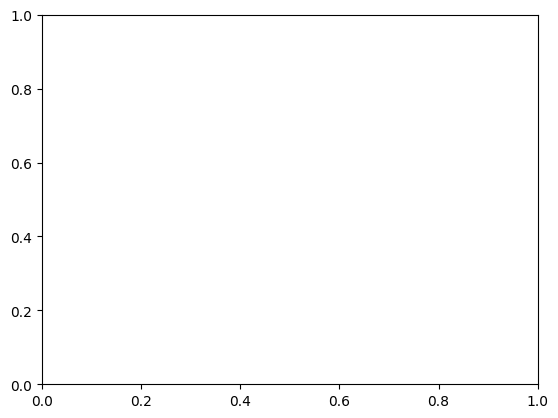

In [37]:
plt.bar(CONVERSIO_HEALTH_df['month'],CONVERSIO_HEALTH_df['WAPD'])

In [40]:
dfp

month,Apr,Aug,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep
PAYMENT_DATE,,,,,,,,,,,,
2022.0000,NaN,NaN,29.9826,NaN,NaN,NaN,NaN,NaN,NaN,29.9069,29.8647,30.2435
2023.0000,24.8068,25.3285,NaN,29.5841,30.0828,26.1582,24.9342,27.5906,24.9288,NaN,NaN,26.5825


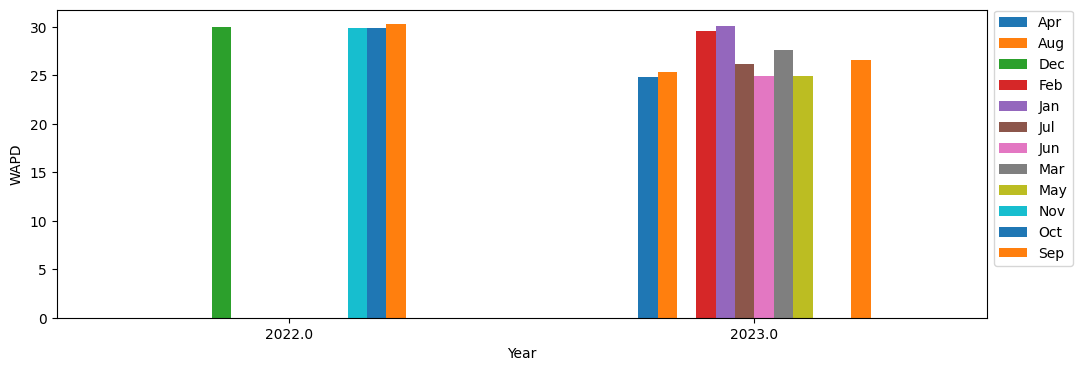

In [39]:
dfp = pd.pivot_table(data=CONVERSIO_HEALTH_df, index=CONVERSIO_HEALTH_df.PAYMENT_DATE.dt.year, columns='month', values='WAPD')

ax = dfp.plot(kind='bar', figsize=(12, 4), ylabel='WAPD', xlabel='Year', rot=0)
_ = ax.legend(bbox_to_anchor=(1, 1.02), loc='upper left')

In [ ]:
# b = pd.read_csv('b.dat')
CONVERSIO_HEALTH_df.index = pd.to_datetime(CONVERSIO_HEALTH_df['PAYMENT_DATE'],format='%m/%d/%y %I:%M%p')
CONVERSIO_HEALTH_df.groupby(by=[CONVERSIO_HEALTH_df.index.month, CONVERSIO_HEALTH_df.index.year])

## EAN

## National Account